In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [12]:
train_set = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
X_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X = train_set.drop("label", axis = 1)
y = train_set["label"]

(29400, 784)

In [3]:
#split training data 70/30. Data augmentation will be used to increase size of training set.
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [50]:
#normalise data using minmax to preserve relative intensities
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_cv_norm = pd.DataFrame(scaler.transform(X_cv), columns = X_cv.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


In [78]:
#augmentation function to add data to training set
from scipy.ndimage import rotate

def augment_data(image, std = 0, max_angle = 0, seed = 0):
    
    rng = np.random.default_rng(seed)
    
    reshaped_image = image.reshape(28, 28)
    rotated_image =rotate(reshaped_image, angle = rng.uniform(-max_angle, max_angle), reshape = False)
    noisy_image = rotated_image + rng.normal(0, std, reshaped_image.shape)
    
    return noisy_image

In [102]:
#convert df into array for transformation
X_train_np = X_train_norm.values
y_train_np = y_train.values
X_cv_np = X_cv_norm.values.reshape(-1, 28, 28)
y_cv_np = y_cv.values

np.random.seed(0)

#augment each image 3 times and concat into labeled sets
aug_data = []
aug_labels = []

for image, label in zip(X_train_np, y_train_np):
    
    aug1 = augment_data(image, std = 0.075, max_angle = 0, seed = 1)
    aug2 = augment_data(image, std = 0, max_angle = 15, seed = 2)
    aug3 = augment_data(image, std = 0.075, max_angle = 20, seed = 3)

    aug_data.extend([image.reshape(28, 28), aug1, aug2, aug3])
    aug_labels.extend([label, label, label, label])


[8, 8, 8, 8, 3, 3, 3, 3]
Image: 28
Label: 3


<function matplotlib.pyplot.show(close=None, block=None)>

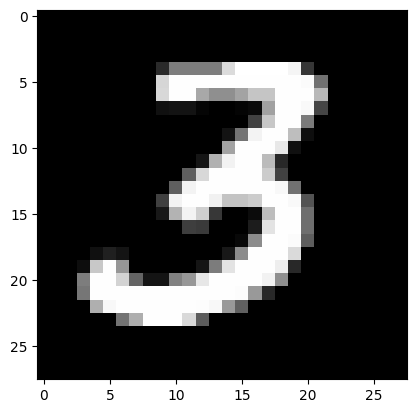

In [85]:
print(aug_labels[24:32])
index = 28
print(f"Image: {index}\nLabel: {aug_labels[index]}")
plt.imshow(aug_data[index], cmap = "gray")
plt.show

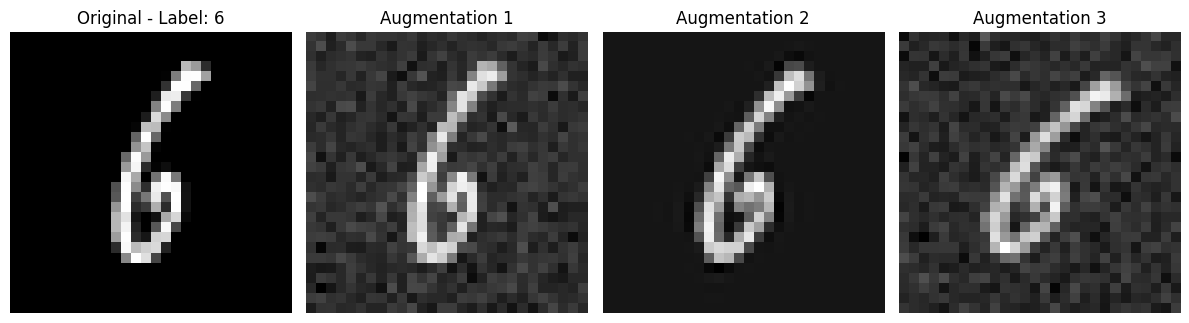

In [86]:
#visualise data augments
import matplotlib.pyplot as plt

def plot_augs(data, labels, index):
   
    images_to_plot = [data[index]] + [data[index + i] for i in range(1, 4)]
    
    fig, axes = plt.subplots(1, len(images_to_plot), figsize=(12, 4))
    
    for i, img in enumerate(images_to_plot):
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")  # Hide axes
        if i == 0:
            axes[i].set_title(f"Original - Label: {labels[index]}")
        else:
            axes[i].set_title(f"Augmentation {i}")

    plt.tight_layout()
    plt.show()

original_image_no = 20
plot_augs(aug_data, aug_labels, original_image_no * 4)

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import Dataset, Dataloader

#convert data into tensors
X_train_torch = torch.tensor(np.array(aug_data)).unsqueeze(1) #add channel dimension to tensor, convert to np array for speed
y_train_torch = torch.tensor(np.array(aug_labels))
X_cv_torch = torch.tensor(np.array(X_cv_np)).unsqueeze(1)
y_cv_torch = torch.tensor(np.array(y_cv))

print(x_train_torch.shape, X_cv_torch.shape, y_train_torch.shape) #[batch_size, channels, height, width]

torch.Size([117600, 1, 28, 28]) torch.Size([12600, 1, 28, 28]) torch.Size([117600])


In [ ]:
#Dataset class for handling batching and shuffling
class CustomDataset(Dataset):
    def __init__(self, images, labels):

        self.images = images #[m, 1, 28, 28]
        self.labels = labels #[m]

    def __len__(self):
        return(len(self.images))

    def __getitem__(self, idx):
        return image[idx], label[idx]

train_dataset = CustomDataset(X_train_torch, y_train_torch)

In [106]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Input size reduced by pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))  # conv1 -> relu -> maxpool
        x = self.pool(F.relu(self.conv2(x)))  # conv2 -> relu -> maxpool
        
        # Flatten the tensor
        x = x.view(-1, 32 * 7 * 7)  # Flatten into (batch_size, num_features)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for the final layer (logits)
        return x

In [107]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [109]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.

    for images, labels in (X_train_torch, y_train_torch):

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

ValueError: too many values to unpack (expected 2)